### pulp+cbcを用いて、ノードを離散化して不在確率込みのTSPを解く

In [1]:
import random, math
import pulp
import itertools
import networkx as nx
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from itertools import combinations, permutations

%matplotlib inline

### データの作成

In [2]:
START_NODE = 0
NUM_NODE = 7
NUM_PERIOD = NUM_NODE + 2
END_NODE = NUM_NODE + 1
AREA_SIZE = 20

In [3]:
list_node_with_start_end = list(range(START_NODE, NUM_NODE + 2))
list_node_with_start = list(range(START_NODE, NUM_NODE + 1))
list_node_with_end = list(range(1, NUM_NODE + 2))
list_node = list(range(1, NUM_NODE + 1))
list_period = list(range(1, NUM_PERIOD + 1))

In [4]:
node_coordinate_map = {}
for n in list_node:
    node_coordinate_map[n] = (random.randint(0, AREA_SIZE), random.randint(0, AREA_SIZE))

In [5]:
node_period_proba_map = {}
for n in list_node:
    for t in list_period:
        node_period_proba_map[n, t] = random.random()

In [6]:
node_node_dist_map = {}
for n1 in list_node:
    for n2 in list_node:
        x = node_coordinate_map[n1]
        y = node_coordinate_map[n2]
        node_node_dist_map[n1, n2] = euclidean(x, y)

### モデルの作成

In [7]:
model = pulp.LpProblem(name='time-dependence-tsp', sense=pulp.LpMinimize)
sense_map = {v: k for k, v in pulp.LpConstraintSenses.items()}

#### 変数の作成

In [8]:
x_ij = {}
for i in list_node_with_start:
    for j in list_node_with_end:
        if i==j:
            continue
            
        if i==START_NODE and j==END_NODE:
            continue
        v = pulp.LpVariable(cat=pulp.LpBinary, name='x_%s_%s'%(i, j))
        x_ij[i, j] = v
        model.addVariable(v)

y_it = {}
for i in list_node_with_start_end:
    for t in list_period:
        v = pulp.LpVariable(cat=pulp.LpBinary, name='y_%s_%s'%(i, t))
        y_it[i, t] = v
        model.addVariable(v)

#### 制約式の作成

In [9]:
constr = pulp.LpConstraint(e=y_it[START_NODE, list_period[0]], sense=sense_map['='], rhs=1, name='first_node_constr')
model.addConstraint(constr)

constr = pulp.LpConstraint(e=y_it[END_NODE, list_period[-1]], sense=sense_map['='], rhs=1, name='end_node_constr')
model.addConstraint(constr)

In [10]:
x_expr = pulp.lpSum(x_ij[START_NODE, i] for i in list_node)
constr = pulp.LpConstraint(e=x_expr, sense=sense_map['='], rhs=1, name='first_edge_constr')
model.addConstraint(constr)

x_expr = pulp.lpSum(x_ij[i, END_NODE] for i in list_node)
constr = pulp.LpConstraint(e=x_expr, sense=sense_map['='], rhs=1, name='end_edge_constr')
model.addConstraint(constr)

In [11]:
for i in list_node_with_start_end:
    y_expr = pulp.lpSum(y_it[i, t] for t in list_period)
    constr = pulp.LpConstraint(e=y_expr, sense=sense_map['='],  rhs=1, name='node_visit_%s'%i)
    model.addConstraint(constr)

In [12]:
BigM = len(list_period)
for i in list_node_with_start:
    for j in list_node_with_end:
        if (i, j) not in x_ij:
            continue
        expr = pulp.lpSum((t + 1)* y_it[i, t] for t in list_period) - pulp.lpSum(t * y_it[j, t] for t in list_period) + \
                   BigM * x_ij[i, j]
        constr = pulp.LpConstraint(e=expr, sense=sense_map['<='], rhs=BigM, name='mtz_%s_%s'%(i, j))
        model.addConstraint(constr)

In [13]:
for i in list_node:
    x_expr = pulp.lpSum(x_ij[j, i] for j in list_node_with_start if (j, i) in x_ij)
    y_expr = pulp.lpSum(y_it[i, t] for t in list_period)
    node_in_constr = pulp.LpConstraint(e=x_expr - y_expr, sense=sense_map['='], rhs=0, name='node_in_%s'%i)
    model.addConstraint(node_in_constr)
    
    x_expr = pulp.lpSum(x_ij[i, j] for j in list_node_with_end if (i, j) in x_ij)
    y_expr = pulp.lpSum(y_it[i, t] for t in list_period)
    node_out_constr = pulp.LpConstraint(e=y_expr - x_expr, sense=sense_map['='], rhs=0, name='node_out_%s'%i)
    model.addConstraint(node_out_constr)

#### 目的関数の作成

In [14]:
objective_physical_dist = pulp.lpSum(node_node_dist_map[i, j] * x_ij[i, j] for i in list_node for j in list_node if (i, j) in x_ij)
objective_penalty_dist = pulp.lpSum(
                                            sum(node_node_dist_map[j, i] / (len(list_node) - 1) for j in list_node) * 
                                            node_period_proba_map[i, t] * 
                                            y_it[i, t] for i in list_node for t in list_period
                                     )

model.setObjective(objective_physical_dist + objective_penalty_dist)

#### 最適化の実行

In [15]:
%%time

model.writeLP('./node_discrete_tsp.lp')
solver = pulp.PULP_CBC_CMD(msg=1, maxSeconds=None, fracGap=0.1, threads=None)
pulp.LpStatus[model.solve(solver=solver)]

Wall time: 4.01 s


#### 最適化の実行（mtzをlazyに追加してみる）

In [16]:
def add_lazy_mtz_constraint(edges):
    """途中解の部分巡回路に対してだけmtz制約を加える
    """
    G = nx.Graph()
    G.add_nodes_from(list_node_with_start_end)
    for (i, j) in edges:
        G.add_edge(i, j)
    list_subtour = list(nx.connected_components(G))
    print('--------subtour--------')
    print(list_subtour, 'n_subtour_%s'%len(list_subtour))
    if len(list_subtour)==1:
        return False

    for subtour in list_subtour:
        for (i, j) in permutations(subtour, 2):
            if (i, j) not in x_ij or 'mtz_%s_%s'%(i, j) in model.constraints:
                continue

            expr = pulp.lpSum((t + 1)* y_it[i, t] for t in list_period) - pulp.lpSum(t * y_it[j, t] for t in list_period) + \
                       len(list_period) * x_ij[i, j]
            constr = pulp.LpConstraint(e=expr, sense=sense_map['<='], rhs=len(list_period), name='mtz_%s_%s'%(i, j))
            model.addConstraint(constr)
    return True

In [17]:
# #%%time

# # mtzをlazy化して最適化する
# # 部分巡回路のための最適化は解が見つかれば十分
# solver_iter = pulp.PULP_CBC_CMD(msg=1, maxSeconds=None, fracGap=0.1, threads=None, options=['maxsol 1'])
# solver_last = pulp.PULP_CBC_CMD(msg=1, maxSeconds=None, fracGap=0.1, threads=None)

# while True:
#     print('solve relax')
#     model.solve(solver=solver_last)
#     edges = []
#     for (i, j) in x_ij:
#         if pulp.value(x_ij[i, j]) >= 0.5:
#             edges.append((i, j))
#     print('-------edges-------')
#     print(edges)
#     if not add_lazy_mtz_constraint(edges=edges):
#         # 線形緩和を解除
#         for (i, j), v in x_ij.items():
#             v.cat = pulp.LpInteger
#             v.lowBound = 0
#             v.upBound = 1
#             x_ij[i, j] = v

#         for (i, t), v in y_it.items():
#             v.cat = pulp.LpInteger
#             v.lowBound = 0
#             v.upBound = 1
#             y_it[i, t] = v

#         for (i, j) in edges:
#             if (i, j) not in x_ij or 'mtz_%s_%s'%(i, j) in model.constraints:
#                 continue
#             expr = pulp.lpSum((t + 1)* y_it[i, t] for t in list_period) - pulp.lpSum(t * y_it[j, t] for t in list_period) + \
#                        len(list_period) * x_ij[i, j]
#             constr = pulp.LpConstraint(e=expr, sense=sense_map['<='], rhs=len(list_period), name='mtz_%s_%s'%(i, j))
#             model.addConstraint(constr)

#         if model.isMIP()==1:
#             model.writeLP('./node_discrete_tsp.lp')
#             model.solve(solver=solver_last)
#             break
#         else:
#             raise Exception('model is not mip')

In [18]:
# xの確認
print('---------x---------')
for (i, j) in x_ij:
    if round(pulp.value(x_ij[i, j]))==1:
        print(i, j)
        
# yの確認
print('--------y----------')
for i in list_node_with_start_end:
    for t in list_period:
        if round(pulp.value(y_it[i, t]))==1:
            print(i, t)

---------x---------
0 5
1 3
2 1
3 7
4 6
5 4
6 2
7 8
--------y----------
0 1
1 6
2 5
3 7
4 3
5 2
6 4
7 8
8 9


### 結果の可視化

In [19]:
node_visitperiod_map = {}
for i in list_node_with_start_end:
    for t in list_period:
        if round(pulp.value(y_it[i, t]))==1:
            node_visitperiod_map[i] = t

In [20]:
# visitするperiod順にpathがつながっていないといけない
list_visit_node = [i[0] for i in sorted(node_visitperiod_map.items(), key=lambda x: x[1])]

list_visit_path = []
for i, j in zip(list_visit_node, list_visit_node[1:]):
    if i==START_NODE or j==END_NODE:
        continue
    if (i, j) in x_ij and round(pulp.value(x_ij[i, j])) == 1:
        list_visit_path.append((i, j))

In [21]:
node_visitproba_map = {}

for k, v in node_visitperiod_map.items():
    if k==START_NODE or k==END_NODE:
        continue
    node_visitproba_map[k] = node_period_proba_map[k, v]

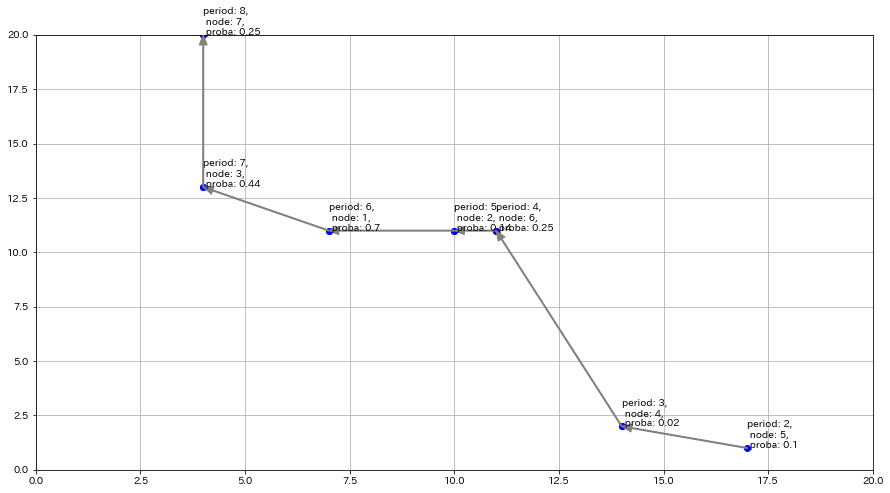

In [22]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

ax.grid()
ax.set_xlim(0, AREA_SIZE)
ax.set_ylim(0, AREA_SIZE)
for i, path in enumerate(list_visit_path, start=1):
    start, end = path[0], path[1]
    # plot start node
    ax.plot(*node_coordinate_map[start], 'o', color='blue')
    visit_period = node_visitperiod_map[start]
    visit_proba = node_visitproba_map[start]
    label = 'period: %s, \n node: %s, \n proba: %s'%(visit_period, start, round(visit_proba, 2))
    ax.annotate(label, xy=node_coordinate_map[start], size=10)

    # plot end node
    ax.plot(*node_coordinate_map[end], 'o', color='blue')
    if i==len(list_visit_path):
        visit_period = node_visitperiod_map[end]
        visit_proba = node_visitproba_map[end]
        label = 'period: %s, \n node: %s, \n proba: %s'%(visit_period, end, round(visit_proba, 2))
        ax.annotate(label, xy=node_coordinate_map[end], size=10)

    # plot arrow
    ax.annotate('', 
                xy=node_coordinate_map[end], xytext=node_coordinate_map[start],
                arrowprops=dict(shrink=0, width=1, headwidth=8, 
                                headlength=10, connectionstyle='arc3',
                                facecolor='gray', edgecolor='gray'))

#### scopを使ってtspを解く

In [23]:
import scop

In [156]:
model = scop.Model('time-dependent-tsp')

In [157]:
list_period = list_node #source-sinkはscopでは使わない

In [158]:
list_node

[1, 2, 3, 4, 5, 6, 7]

In [159]:
# 変数を作る
x_i = {}
for i in list_node:
    v = model.addVariable(name='x_%s'%i, domain=list_period)
    x_i[i] = v

In [160]:
all_diff_constr = scop.Alldiff(name='all_diff', varlist=x_i.values(), weight='inf')
model.addConstraint(all_diff_constr)

In [161]:
# 目的関数（物理距離）
phys_dist_constr = scop.Quadratic(name='phys_dist', direction='<=', rhs=0, weight=1)
for i, j in list(itertools.permutations(list_node, 2)):
    for t in list_period[1:]:
        phys_dist_constr.addTerms(int(node_node_dist_map[i, j]), x_i[i], t-1, x_i[j], t)
        
model.addConstraint(phys_dist_constr)

In [162]:
# 目的関数（有効距離）
effect_dist_constr = scop.Linear(name='effect_dist', direction='<=', rhs=0, weight=1)
for i in list_node:
    for t in list_period:
        coeff = sum(node_node_dist_map[j, i] / (len(list_node) - 1) for j in list_node) * node_period_proba_map[i, t]
        coeff = int(round(coeff, 0)) # 係数はintじゃないとだめっぽい
        effect_dist_constr.addTerms(coeff, x_i[i], t)
        
model.addConstraint(effect_dist_constr)

In [163]:
model.optimize()


 ================ Now solving the problem ================ 



({'x_1': '4',
  'x_2': '5',
  'x_3': '7',
  'x_4': '1',
  'x_5': '2',
  'x_6': '3',
  'x_7': '6'},
 {'effect_dist': 17, 'phys_dist': 38})

In [164]:
model.Status

0